---

**Load essential libraries**

---

In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

import tensorflow as tf

---

**Check TensorFlow version**

---

In [20]:
tf.__version__

'2.12.1'

---

Load MNIST Data

---

In [21]:
## Load MNIST data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

num_labels = len(np.unique(y_train))
num_features = X_train.shape[1]
num_samples = X_train.shape[0]

# One-hot encode class labels
Y_train = tf.keras.utils.to_categorical(y_train)
Y_test = tf.keras.utils.to_categorical(y_test)

# Normalize the samples (images)
xmax = np.amax(X_train)
xmin = np.amin(X_train)
X_train = (X_train - xmin) / (xmax - xmin) # all train features turn into a number between 0 and 1
X_test = (X_test - xmin)/(xmax - xmin)

print('MNIST set')
print('---------------------')
print('Number of training samples = %d'%(num_samples))
print('Number of features = %d'%(num_features))
print('Number of output labels = %d'%(num_labels))

MNIST set
---------------------
Number of training samples = 60000
Number of features = 784
Number of output labels = 10


---

We will now look at 3 different ways to build custom models using TensorFlow 2:

1. model subclassing ([Making new layers and models via subclassing](https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing))
2. sequential API
3. functional API

---

---

**Approach-1**: here we build the model by subclassing the Keras $\texttt{Model}$ class followed by definition of of layers in $\texttt{__init__}$ and implementation of the model's forward pass in $\texttt{call()}$.

---

In [22]:
## Define 1-layer (softmax) neural network architecture
# Define model
class Softmax_Model(tf.keras.models.Model):
    def __init__(self):
        super(Softmax_Model, self).__init__()
        initializer = tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5)
        self.dense1 = tf.keras.layers.Dense(num_labels, dtype = 'float64',\
                                 bias_initializer = initializer,\
                                 activation = tf.keras.activations.softmax)

    # Forward pass for the model
    def call(self, inputs):
        a = self.dense1(inputs)
        return a

In [23]:
## Define 2-layer (softmax) neural network architecture
# Define model

class Softmax_Model(tf.keras.models.Model):
    def __init__(self):
        super(Softmax_Model, self).__init__()
        initializer = tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5)
        self.dense1 = tf.keras.layers.Dense(num_labels, dtype='float64',
                                                bias_initializer=initializer,
                                                activation=tf.keras.layers.LeakyReLU(alpha=0.2))
        
        self.dense2 = tf.keras.layers.Dense(num_labels, dtype='float64',
                                                bias_initializer=initializer,
                                                activation=tf.keras.activations.softmax)

    # Forward pass for the model
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)
activation = tf.keras.activations.softmax


---

Build model

---

In [24]:
## Build model
model = Softmax_Model()
batch_size = 100 # batch size
model.build((batch_size, num_features))

c:\Users\adity\anaconda3\Lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


---

Compile and train the model on the training batches and test on the test set in one shot

---

In [25]:
## Compile model
opt = tf.keras.optimizers.Adam(learning_rate = 1e-03) # optimizer
loss_fn = tf.keras.losses.CategoricalCrossentropy()  # loss function
model.compile(optimizer = opt, loss = loss_fn, metrics = ['acc'])

# Train model and simultabeously test on the test set
model.fit(X_train, Y_train, batch_size = 100,\
          epochs = 10,\
          validation_data = (X_test, Y_test))

Epoch 1/10


600/600 [==============================] - 1s 1ms/step - loss: 0.7032 - acc: 0.8033 - val_loss: 0.3430 - val_acc: 0.9058
Epoch 2/10
600/600 [==============================] - 1s 1ms/step - loss: 0.3232 - acc: 0.9094 - val_loss: 0.2859 - val_acc: 0.9186
Epoch 3/10
600/600 [==============================] - 1s 1ms/step - loss: 0.2854 - acc: 0.9188 - val_loss: 0.2707 - val_acc: 0.9216
Epoch 4/10
600/600 [==============================] - 1s 1ms/step - loss: 0.2672 - acc: 0.9239 - val_loss: 0.2576 - val_acc: 0.9273
Epoch 5/10
600/600 [==============================] - 1s 1ms/step - loss: 0.2548 - acc: 0.9277 - val_loss: 0.2526 - val_acc: 0.9293
Epoch 6/10
600/600 [==============================] - 1s 1ms/step - loss: 0.2469 - acc: 0.9300 - val_loss: 0.2468 - val_acc: 0.9289
Epoch 7/10
600/600 [==============================] - 1s 1ms/step - loss: 0.2399 - acc: 0.9324 - val_loss: 0.2461 - val_acc: 0.9285
Epoch 8/10
600/600 [==============================] - 1s 1ms/step - loss: 0.2350 - acc:

---

Instead of doing the above, we can explicitly write down the optimization step using $\texttt{GradientTape()}$ and train the model

---

In [26]:
## Create source dataset from input data (this is helpful for ppipelining later)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
batch_size = 100 # batch size
# Create training batches
train_dataset = train_dataset.shuffle(buffer_size = 1024).batch(batch_size)

In [27]:
# Create softmax model
model = Softmax_Model()

opt = tf.keras.optimizers.Adam(learning_rate = 1e-03) # optimizer
loss_fn = tf.keras.losses.CategoricalCrossentropy()  # loss function

# Varible to store training loss per epoch
loss_train_epoch = tf.keras.metrics.Mean()

# Iterate over epochs
nepochs = 10
for epoch in range(nepochs):
  # Iterate over the batches of the dataset.
  for step, train_batch in enumerate(train_dataset):
    with tf.GradientTape() as g:
      # Compute loss
      yhat = model(train_batch[0])
      loss = loss_fn(train_batch[1], yhat)

    # Calculate gradients
    grad = g.gradient(loss, model.trainable_weights)

    # Update model
    opt.apply_gradients(zip(grad, model.trainable_weights))

    # Append training loss
    loss_train_epoch(loss)
  print('Epoch %d: train loss = %f'%(epoch+1, loss_train_epoch.result()))

Epoch 1: train loss = 0.775305
Epoch 2: train loss = 0.555789
Epoch 3: train loss = 0.467661
Epoch 4: train loss = 0.418704
Epoch 5: train loss = 0.386968
Epoch 6: train loss = 0.364287
Epoch 7: train loss = 0.347079
Epoch 8: train loss = 0.333447
Epoch 9: train loss = 0.322344
Epoch 10: train loss = 0.313078


In [28]:
# Compile model so it can be evaluated for test set
model.compile(optimizer = opt, loss = loss_fn, metrics = ['acc'])
print('\nAccuracy:', model.evaluate(X_test, Y_test, verbose=0)[1])


Accuracy: 0.9311000108718872


---

**Approach-2**: here we build the model using the sequential API of TensorFlow Keras. Try this.

---

Epoch 1/10
600/600 [==============================] - 1s 2ms/step - loss: 0.3504 - accuracy: 0.9013 - val_loss: 0.1651 - val_accuracy: 0.9487
Epoch 2/10
600/600 [==============================] - 1s 2ms/step - loss: 0.1445 - accuracy: 0.9573 - val_loss: 0.1237 - val_accuracy: 0.9631
Epoch 3/10
600/600 [==============================] - 1s 2ms/step - loss: 0.1052 - accuracy: 0.9678 - val_loss: 0.1080 - val_accuracy: 0.9668
Epoch 4/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0829 - accuracy: 0.9752 - val_loss: 0.0894 - val_accuracy: 0.9718
Epoch 5/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0683 - accuracy: 0.9786 - val_loss: 0.0822 - val_accuracy: 0.9730
Epoch 6/10
600/600 [==============================] - 1s 1ms/step - loss: 0.0574 - accuracy: 0.9822 - val_loss: 0.0872 - val_accuracy: 0.9733
Epoch 7/10
600/600 [==============================] - 1s 1ms/step - loss: 0.0498 - accuracy: 0.9841 - val_loss: 0.0823 - val_accuracy: 0.9733
Epoch 

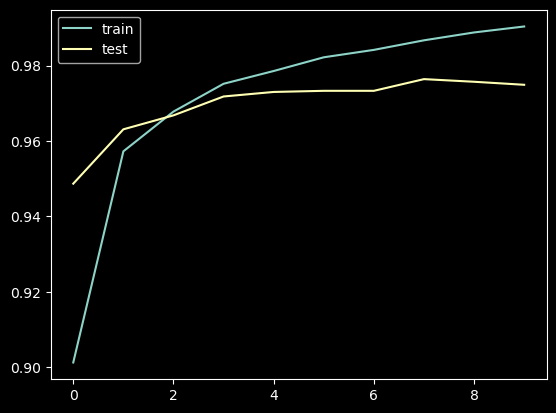

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the model
model = Sequential()

# Add layers to the model
model.add(Dense(64, activation='relu', input_shape=(num_features,)))
model.add(Dense(128, activation='relu'))  # Modify this line to have 128 nodes
model.add(Dense(num_labels, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=100, validation_data=(X_test, Y_test))


---

**Approach-3**: here we build the model using the functional API of TensorFlow Keras. Try this.

---

Epoch 1/10
600/600 [==============================] - 1s 2ms/step - loss: 0.3411 - accuracy: 0.9042 - val_loss: 0.1706 - val_accuracy: 0.9463
Epoch 2/10
600/600 [==============================] - 1s 1ms/step - loss: 0.1489 - accuracy: 0.9564 - val_loss: 0.1258 - val_accuracy: 0.9607
Epoch 3/10
600/600 [==============================] - 1s 1ms/step - loss: 0.1079 - accuracy: 0.9675 - val_loss: 0.1109 - val_accuracy: 0.9648
Epoch 4/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0841 - accuracy: 0.9747 - val_loss: 0.0947 - val_accuracy: 0.9715
Epoch 5/10
600/600 [==============================] - 1s 1ms/step - loss: 0.0683 - accuracy: 0.9786 - val_loss: 0.0902 - val_accuracy: 0.9708
Epoch 6/10
600/600 [==============================] - 1s 1ms/step - loss: 0.0574 - accuracy: 0.9824 - val_loss: 0.0901 - val_accuracy: 0.9715
Epoch 7/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0491 - accuracy: 0.9847 - val_loss: 0.0919 - val_accuracy: 0.9725
Epoch 

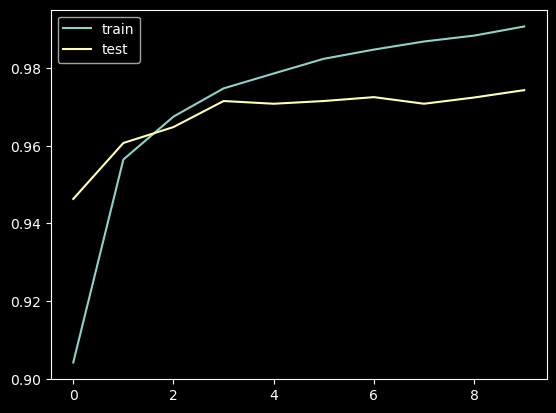

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define input layer
inputs = Input(shape=(num_features,))

# Define hidden layers
x = Dense(64, activation='relu')(inputs)
x = Dense(128, activation='relu')(x)

# Define output layer
outputs = Dense(num_labels, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=100, validation_data=(X_test, Y_test))

# Plot the training history
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()
